# Hidden Markov Models

## Configuration

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

MODEL_NAME = 'test.hmm'
SEQUENCES_NAME = 'sequences.txt'
KEYS = ['hidden', 'observables', 'pi', 'transitions', 'emissions']

## Model Parser

In [2]:
def split_line(l, t=str, c=' '):
    """Returns an array of values from a line"""
    return  [ t(x) for x in l.split(c) ]


def dict_with_indexes(l):
    """Returns a dictionary with key:index from an array"""
    return { l[i]: i for i in range(len(l)) }


def load_model(filename):
    """Loads the data and returns a dictionary with some kind of helpful structure"""
    data = {}
    # just fetch the lines which are not empty
    with open(filename, 'r') as f:
        EOF = False
        while not EOF:
            l = f.readline().strip('\n')
            if l == KEYS[0]: #'hidden'
                # one line
                # format {'i':0, ...}
                data[KEYS[0]] = dict_with_indexes( split_line(f.readline().strip('\n')) ) 
            elif l == KEYS[1]: #'observables'
                # one line
                # format {'a':0,...}
                data[KEYS[1]] = dict_with_indexes( split_line(f.readline().strip('\n')) ) 
            elif l == KEYS[2]: #'pi'
                # one line
                # format [0.3, ...]
                data[KEYS[2]] = split_line(f.readline().strip('\n'), t=float)
            elif l == KEYS[3]: #'transitions'
                # multiple lines
                #format [[0.2,..], [...]]
                data[KEYS[3]] = [ split_line(f.readline().strip('\n'), t=float) for x in range(len(data[KEYS[0]].keys())) ] 
            elif l == KEYS[4]: #'emissions'
                # multiple lines
                #format [[0.2,..], [...]]
                data[KEYS[4]] = [ split_line(f.readline().strip('\n'), t=float) for x in range(len(data[KEYS[0]].keys())) ]    
                # this is supposed to be the last line of our data
                EOF = True      
    return data


def show_model(data):
    """Prints the data"""
    # print the hidden states
    for key in KEYS:
        print key
        print data[key]

## Sequences Parser

In [3]:
def load_sequences(filename):
    data = {}
    # just fetch the lines which are not empty
    with open(filename, 'r') as f:
        lines = f.readlines()
        x = 0
        while x < len(lines):
            name = lines[x].strip('\n').lstrip('>')
            x += 1
            emissions = lines[x].strip('\n').lstrip(' ')
            x += 1
            hiddens = lines[x].strip('\n').lstrip('# ')
            x += 2
            data[name] = dict(X=emissions, Z=hiddens, name=name)
    return data

## Loading model and sequences

In [4]:
model = load_model(MODEL_NAME)
sequences = load_sequences(SEQUENCES_NAME)

In [5]:
# useful functions
def transition(a, b):
    """a and b are indexes of hidden states"""
    return model['transitions'][a][b]


def emission(a, b):
    """a is an index of a hidden state, b is an index of an emission"""
    return model['emissions'][a][b]

## computing the likelihood of the markov hidden model

In [19]:
# compute
def compute_hmm(model, sequence):

    input_states = sequence['Z']
    input_emissions = sequence['X']
    states_indexes = model['hidden']
    observables_indexes = model['observables']
    # the first state
    i = 0
    pr = 0.0
    PI = math.log( model['pi'][ states_indexes[input_states[i]] ] )
    S = PI
    # first hidden and emission nodes
    S += math.log( emission(states_indexes[input_states[i]], observables_indexes[input_emissions[i]]) )
    for i in range(1, len(input_states)):
        S += math.log( transition(states_indexes[input_states[i - 1]], states_indexes[input_states[i]]) )
        S += math.log( emission(states_indexes[input_states[i]], observables_indexes[input_emissions[i]]) )
        
    return (sequence['name'], S)
        
        
results = {}
for key in sequences.keys():
    results[key] =  compute_hmm(model, sequences[key])[1]

## Data plots

In [15]:
# teacher results
t_results = {
    'FTSH_ECOLI':-1885.4977658,'GAA1_CHICK':-1354.42230075,'GAA4_BOVIN': -1648.49027393,'GAB1_HUMAN':  -1410.78488617,
    'GAB_LYMST': -1486.03455155,'GAC1_RAT': -1400.15967778,'GAD_MOUSE': -1337.21101494,'GAR1_HUMAN':  -1411.53682112,
    'GAR2_HUMAN': -1388.92141857,'GRA1_HUMAN': -1348.3724723,'GRB_RAT': -1476.92146295,'HOXN_ALCEU':  -1047.95694027,
    'IMMA_CITFR':  -521.400433575,'KDGL_ECOLI':  -363.533530068,'RFBP_SALTY':  -1422.86536912,'RIB1_RAT':  -1758.94267129,
}

m_results = {
    'FTSH_ECOLI': -2199.316136837176,'GAA1_CHICK': -1647.7364810332324,'GAA4_BOVIN': -1988.1239216046022,
    'GAB1_HUMAN':  -1704.564227952754,'GAB_LYMST': -1790.5026831331786,'GAC1_RAT': -1683.6582081866618,
    'GAD_MOUSE': -1621.574783562823,'GAR1_HUMAN':  -1711.2157808677623,'GAR2_HUMAN': -1679.6546385618474,
    'GRA1_HUMAN': -1625.9145151618247,'GRB_RAT': -1786.5290935800676,'HOXN_ALCEU':  -1256.165560233634,
    'IMMA_CITFR':  -641.282361032329,'KDGL_ECOLI':  -356.3995964985915,'RFBP_SALTY':  -1695.117962426908,
    'RIB1_RAT':  -2185.5638351566477,
}

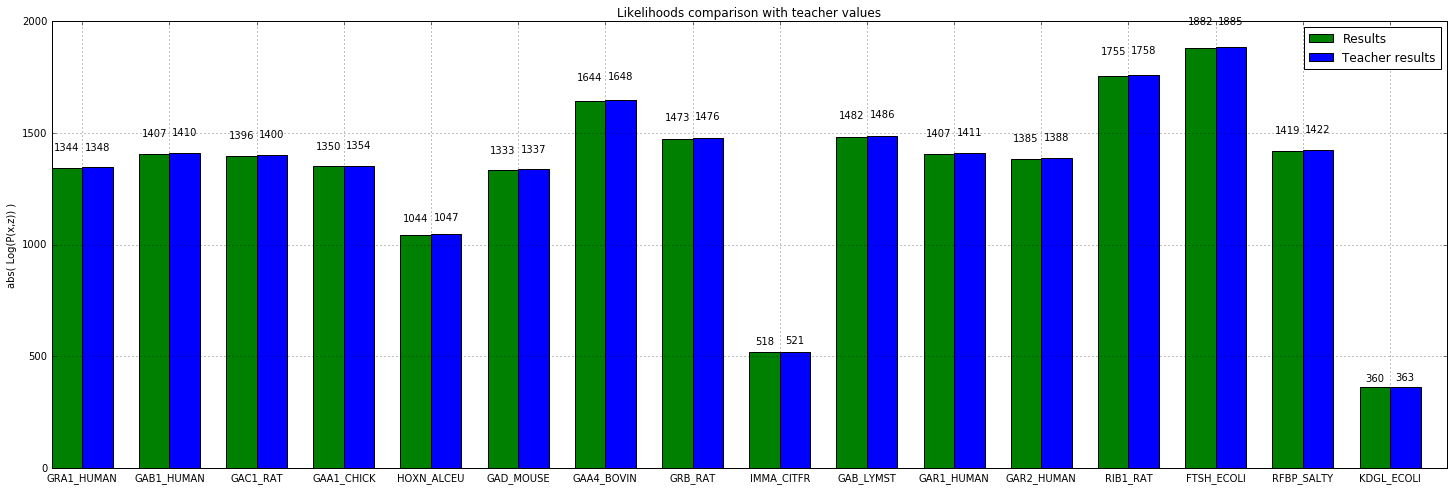

In [12]:
xAxis = [ x for x in results.keys()]
x1 = np.arange(len(results.keys()))
y1 = [ abs(results[x]) for x in xAxis ]
y2 = [ abs(t_results[x])  for x in xAxis ]


width = 0.35
fig = plt.figure(figsize=(25, 8), dpi=200)
ax = fig.add_subplot(111)
rect1 = ax.bar(x1, y1, width, color='g')
rect2 = ax.bar(x1 + width, y2, width, color='b')


ax.set_xticks(x1+width)
ax.set_ylabel('abs( Log(P(x,z)) )')
ax.set_title('Likelihoods comparison with teacher values')
ax.set_xticklabels(xAxis)

ax.legend((rect1[0], rect2[0]), ('Results', 'Teacher results'))

def autolabel(rects):
    for rect in rects:
        h = rect.get_height()
        ax.text(rect.get_x()+rect.get_width()/2., 1.05*h, '%d'%int(h),
                ha='center', va='bottom')

autolabel(rect1)
autolabel(rect2)

plt.grid(True)
plt.show()

In [20]:
results

{'FTSH_ECOLI': -1885.4977657957534,
 'GAA1_CHICK': -1354.4223007486369,
 'GAA4_BOVIN': -1648.490273934017,
 'GAB1_HUMAN': -1410.7848861687885,
 'GAB_LYMST': -1486.0345515495878,
 'GAC1_RAT': -1400.159677776142,
 'GAD_MOUSE': -1337.2110149427608,
 'GAR1_HUMAN': -1411.5368211191098,
 'GAR2_HUMAN': -1388.9214185657202,
 'GRA1_HUMAN': -1348.3724723014802,
 'GRB_RAT': -1476.9214629535718,
 'HOXN_ALCEU': -1047.9569402708287,
 'IMMA_CITFR': -521.4004335750133,
 'KDGL_ECOLI': -363.53353006844713,
 'RFBP_SALTY': -1422.8653691183783,
 'RIB1_RAT': -1758.942671287108}